In [40]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)

In [41]:
source('milo_cellbender.R')

In [42]:
obj_neuron = qs::qread('_targets/objects/obj_neuron') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_neuron

An object of class Seurat 
29128 features across 104587 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



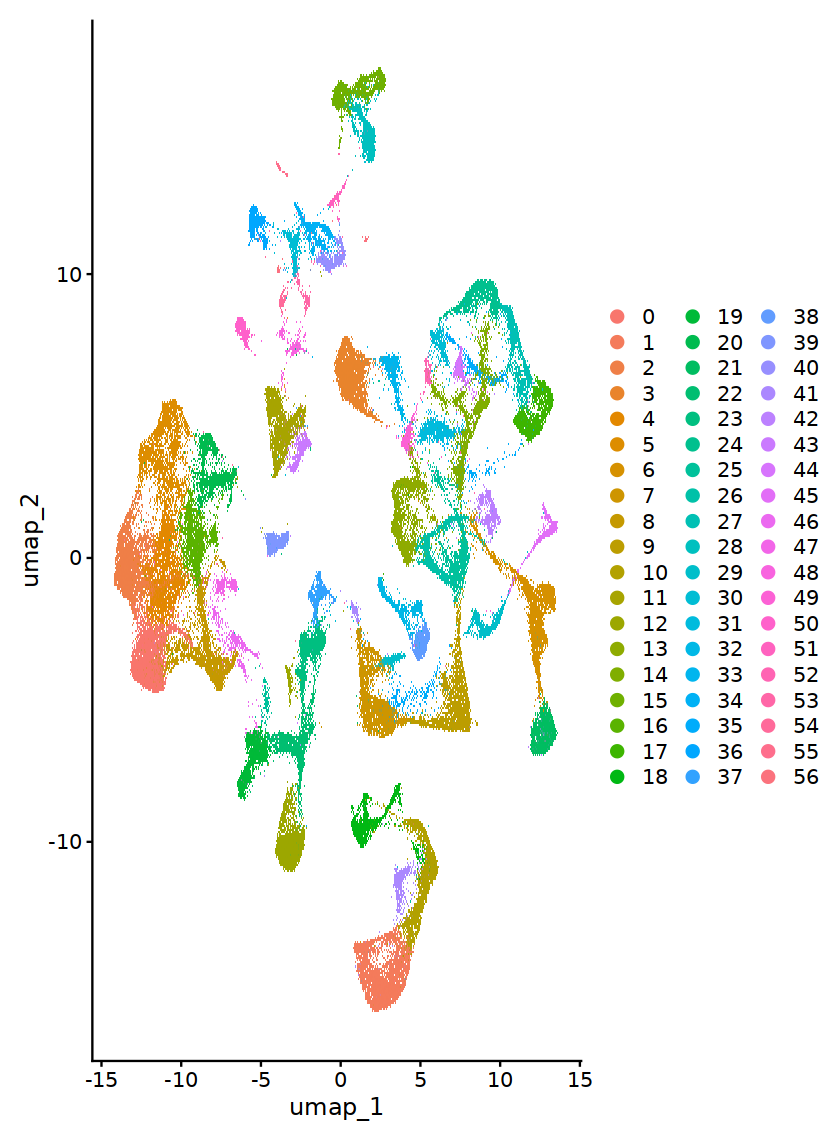

In [43]:
DimPlot(obj_neuron)

In [44]:
obj_other = qs::qread('_targets/objects/obj_other') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_other

An object of class Seurat 
25033 features across 29782 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

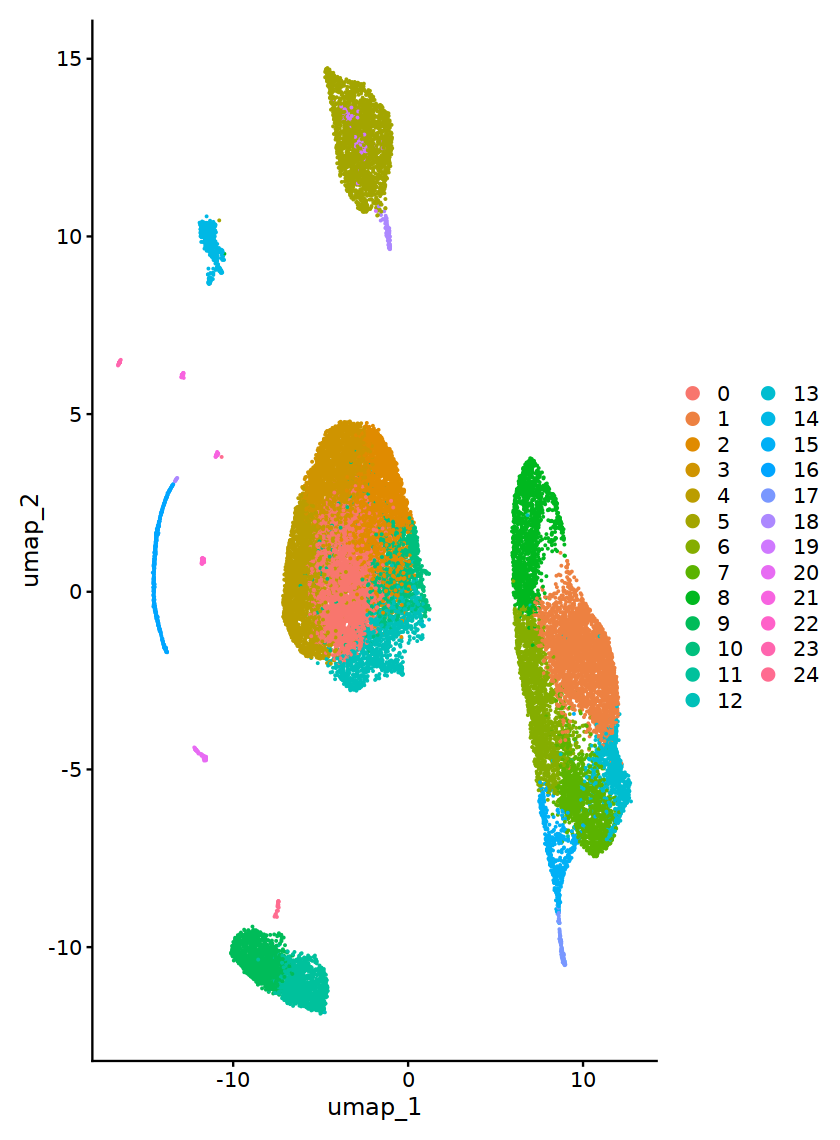

In [45]:
DimPlot(obj_other)

In [46]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))


In [47]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,1.060039,-9.89935829
2,SI-TT-A11_AAACCCACATACAGCT,4.324369,1.16208909
3,SI-TT-A11_AAACCCACATGAGGGT,4.696438,-3.14927985
4,SI-TT-A11_AAACCCAGTACGTTCA,1.344125,-13.86531212
5,SI-TT-A11_AAACCCATCCAAGCAT,-5.445605,12.35118530
6,SI-TT-A11_AAACCCATCCCATAAG,-9.186716,0.09222025


In [48]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,9.741567,-6.3410525
2,SI-TT-A11_AAACGAAAGGTTCTTG,-8.439921,-10.6500720
3,SI-TT-A11_AAACGAACAAGGAGTC,-3.407435,-0.5645014
4,SI-TT-A11_AAACGAACAGCCTTCT,-4.795028,1.1611348
5,SI-TT-A11_AAACGCTAGTGCTAGG,12.090093,-5.6987538
6,SI-TT-A11_AAAGGATTCAACCCGG,8.568621,-2.9679698


In [49]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [50]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 134369      3

In [51]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6')
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 26179    18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-A11_GCCGTGAGTCAGGTGA,92
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_AACCACACAGTAGAGC,66
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_TCCCATGTCTTCGGTC,60
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,FALSE,pos_away,pos_away,pos,pos,SI-TT-A11_CATCGGGAGAATAGTC,113
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-E12_TCCTGCATCAAGAATG,96
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-F10_AACCAACGTTCCTACC,76


In [52]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC)


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 26179    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,7.515957,12.97996,379.8192,1.207241e-33,4.044256e-31,42,1.966418e-31,pos,Agrp,1,112,SI-TT-F10_GATGTTGCATGTGACT
2,8.003707,12.95989,399.9349,3.060410e-33,5.126187e-31,220,3.332260e-31,pos,Agrp,1,111,SI-TT-G10_TTCTTCCCACGGTGTC
3,7.953393,12.92120,384.8309,1.130030e-32,1.261867e-30,97,7.442757e-31,pos,Agrp,1,107,SI-TT-G10_ACTTCGCGTCGGTACC
4,7.949918,12.94269,372.9086,3.266295e-32,2.735522e-30,164,1.527553e-30,pos,Agrp,1,108,SI-TT-E12_CTGCCTATCCCGAGGT
5,7.894118,12.88443,350.5554,2.582050e-31,1.729974e-29,168,9.649162e-30,pos,Agrp,1,104,SI-TT-F10_AGGTCTAAGGAATTAC
6,7.849137,12.80822,320.1283,5.153435e-30,2.877335e-28,278,1.725157e-28,pos,Agrp,1,98,SI-TT-G10_GCTCAAACAGGCTACC


In [53]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_all.obob5v5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 26179    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,none,Agrp,1,92,SI-TT-A11_GCCGTGAGTCAGGTGA
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,none,Agrp,1,66,SI-TT-A11_AACCACACAGTAGAGC
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,none,Agrp,1,60,SI-TT-A11_TCCCATGTCTTCGGTC
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,none,Agrp,1,113,SI-TT-A11_CATCGGGAGAATAGTC
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,none,Agrp,1,96,SI-TT-E12_TCCTGCATCAAGAATG
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,none,Agrp,1,76,SI-TT-F10_AACCAACGTTCCTACC


In [54]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,none,Agrp,1,⋯,-0.2424385,12.34419,0.09743931,7.555388e-01,7.693176e-01,7.665743e-01,none,1,92,SI-TT-A11_GCCGTGAGTCAGGTGA
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,none,Agrp,1,⋯,3.8260158,12.22238,23.88893487,3.980409e-06,1.960937e-05,1.555434e-05,pos,1,66,SI-TT-A11_AACCACACAGTAGAGC
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,none,Agrp,1,⋯,4.7154770,12.17780,35.62383667,4.412047e-08,2.383928e-07,1.840213e-07,pos,1,60,SI-TT-A11_TCCCATGTCTTCGGTC
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,none,Agrp,1,⋯,-2.0791355,12.49469,4.69548788,3.255118e-02,3.622806e-02,3.515414e-02,neg,1,113,SI-TT-A11_CATCGGGAGAATAGTC
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,none,Agrp,1,⋯,1.3300829,12.46317,3.52514028,6.372094e-02,7.045054e-02,6.848548e-02,pos,1,96,SI-TT-E12_TCCTGCATCAAGAATG
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,none,Agrp,1,⋯,5.7372345,12.45117,98.03740742,1.658845e-16,9.110050e-16,6.976537e-16,pos,1,76,SI-TT-F10_AACCAACGTTCCTACC


In [55]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 26179    39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,2.450720,12.34419,16.40508,9.772404e-05,0.006547510,8,0.007936154,pos,Agrp,1,⋯,0.09743931,7.555388e-01,7.693176e-01,7.665743e-01,none,1,92,neuron,4.024358,-13.21293
2,4.058845,12.22238,17.81574,5.438004e-05,0.006072437,88,0.007936154,pos,Agrp,1,⋯,23.88893487,3.980409e-06,1.960937e-05,1.555434e-05,pos,1,66,neuron,3.799933,-12.97150
3,4.511316,12.17780,18.34746,4.512404e-05,0.006072437,135,0.007936154,pos,Agrp,1,⋯,35.62383667,4.412047e-08,2.383928e-07,1.840213e-07,pos,1,60,neuron,3.227394,-13.47334
4,2.180880,12.49469,16.47512,9.630118e-05,0.006547510,268,0.007936154,pos,Agrp,1,⋯,4.69548788,3.255118e-02,3.622806e-02,3.515414e-02,neg,1,113,neuron,4.279744,-13.61656
5,3.069050,12.46317,18.80759,3.801917e-05,0.006072437,326,0.007936154,pos,Agrp,1,⋯,3.52514028,6.372094e-02,7.045054e-02,6.848548e-02,pos,1,96,neuron,3.307137,-13.49501
6,3.369903,12.45117,15.83611,1.310836e-04,0.007318835,167,0.009178620,pos,Agrp,1,⋯,98.03740742,1.658845e-16,9.110050e-16,6.976537e-16,pos,1,76,neuron,4.424284,-13.29926


In [56]:
da_results_restored 

logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.450720,12.34419,16.405083,9.772404e-05,0.006547510,8,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-A11_GCCGTGAGTCAGGTGA,92
4.058845,12.22238,17.815742,5.438004e-05,0.006072437,88,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_AACCACACAGTAGAGC,66
4.511316,12.17780,18.347462,4.512404e-05,0.006072437,135,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_TCCCATGTCTTCGGTC,60
2.180880,12.49469,16.475121,9.630118e-05,0.006547510,268,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,FALSE,pos_away,pos_away,pos,pos,SI-TT-A11_CATCGGGAGAATAGTC,113
3.069050,12.46317,18.807591,3.801917e-05,0.006072437,326,0.007936154,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-E12_TCCTGCATCAAGAATG,96
3.369903,12.45117,15.836112,1.310836e-04,0.007318835,167,0.009178620,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-F10_AACCAACGTTCCTACC,76
3.237844,12.20964,14.975725,1.886269e-04,0.009027144,314,0.011428638,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-H10_GGTTCTCCAACCAGAG,66
2.096936,12.42957,14.560063,2.320691e-04,0.009717894,47,0.011964036,pos,Agrp,1,all.obob5v5__v__all.obobBL6,FALSE,pos_away,pos_away,pos,pos,SI-TT-H10_CAGTTAGTCCGTCCTA,106
3.492525,12.20746,14.204290,2.800721e-04,0.010424908,284,0.012926995,pos,Agrp,1,all.obob5v5__v__all.obobBL6,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_ATATCCTAGCGCACAA,64


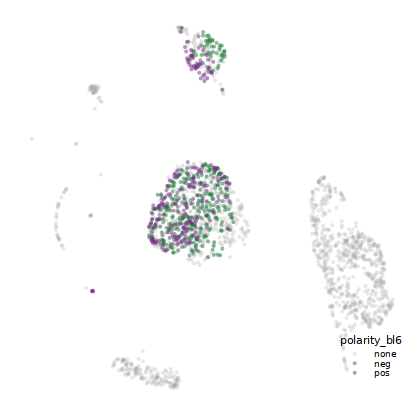

In [57]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

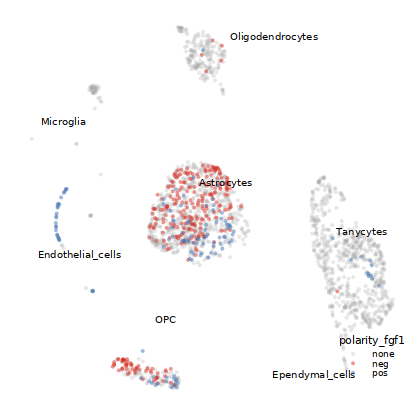

In [58]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

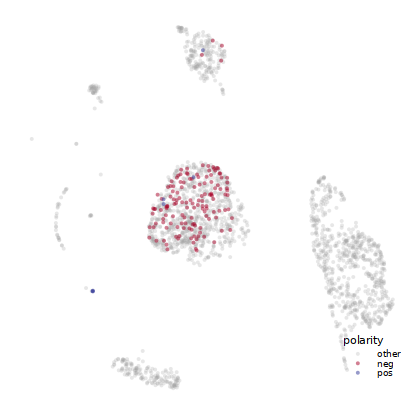

In [59]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [60]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'all.obob5v5__v__all.obobBL6') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
other,1718,408,187,221,0.4583333,152,34,21,13,0.2236842,0.08333333,all.obob5v5__v__all.obobBL6,0.2374854,0.08847497,0.3259604,560
g2,868,290,89,201,0.3068966,467,122,5,117,0.2612420,0.42068966,all.obob5v5__v__all.obobBL6,0.3341014,0.53801843,0.8721198,757
Astrocytes,910,284,66,218,0.2323944,487,137,3,134,0.2813142,0.48239437,all.obob5v5__v__all.obobBL6,0.3120879,0.53516484,0.8472527,771
OPC,182,95,41,54,0.4315789,0,0,0,0,NaN,0.00000000,all.obob5v5__v__all.obobBL6,0.5219780,0.00000000,0.5219780,95
Htr3b,254,90,28,62,0.3111111,93,18,5,13,0.1935484,0.20000000,all.obob5v5__v__all.obobBL6,0.3543307,0.36614173,0.7204724,183
g3,349,80,36,44,0.4500000,0,0,0,0,NaN,0.00000000,all.obob5v5__v__all.obobBL6,0.2292264,0.00000000,0.2292264,80


[1] "other"               "g2"                  "Astrocytes"         
 [4] "OPC"                 "Htr3b"               "g3"                 
 [7] "neuron"              "Trh__Lef1"           "n1"                 
[10] "g1"                  "Agrp"                "Tanycytes"          
[13] "Irx5__Lmx1a"         "n0"                  "Ghrh"               
[16] "n8"                  "Oligodendrocytes"    "Kiss1__Tac2"        
[19] "n_drop"              "Endothelial_cells"   "Pomc__Glipr1"       
[22] "Nfib_3"              "Nfix__Nfib__Lhx6"    "Pomc__Ttr"          
[25] "Pou6f2__Prkcq__Whrn" "Ppp1r17__Tafa4"      "Arx__Nr5a2"         
[28] "Dlk1"                "Ependymal_cells"     "Esr1"               
[31] "Fez1"                "Gpr50__Tac2"         "Hdc"                
[34] "Lepr15"              "Lepr67"              "Lepr89"             
[37] "Lpar1_oligo"         "Met__Pappa2"         "Met__Prlh"          
[40] "Microglia"           "Nfib_1"              "Nfib_2"             
[43] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Npsr1__Epha3"       
[46] "Pomc__Anxa2"         "Ppp1r17"             "Ppp1r17__Ltbp1"     
[49] "Reln__Lef1"          "Sim1"                "Slc17a6__Trhr"      
[52] "Sst__Nts"            "Sst__Pthlh"          "Sst__Unc13c"        
[55] "Tbx19__Pirt"         "Th__Nfib"            "Th__Slc6a3"         
[58] "Tmem215__Dach2"      "Tmem215__Greb1"      "Trh__Cxcl12"        
[61] "g4"                  "g_drop"              "n2"                 
[64] "n3"                  "n4"                  "n5"                 
[67] "n6"

In [61]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,26
other,5
NA,14


In [62]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Agrp,335,14,13,1,0.9285714,306,8,7,1,0.02614379,0.5714286,all.obob5v5__v__all.obobBL6,0.041791045,0.913432836,0.95522388,320,neuron
Htr3b,254,90,28,62,0.3111111,93,18,5,13,0.19354839,0.2000000,all.obob5v5__v__all.obobBL6,0.354330709,0.366141732,0.72047244,183,neuron
Kiss1__Tac2,213,4,2,2,0.5000000,153,4,2,2,0.02614379,1.0000000,all.obob5v5__v__all.obobBL6,0.018779343,0.718309859,0.73708920,157,neuron
Trh__Cxcl12,268,0,NA,NA,NA,147,0,0,0,0.00000000,NaN,all.obob5v5__v__all.obobBL6,0.000000000,0.548507463,0.54850746,147,neuron
Ghrh,148,9,9,NA,1.0000000,105,9,9,0,0.08571429,1.0000000,all.obob5v5__v__all.obobBL6,0.060810811,0.709459459,0.77027027,114,neuron
Tmem215__Greb1,173,0,NA,NA,NA,114,0,0,0,0.00000000,NaN,all.obob5v5__v__all.obobBL6,0.000000000,0.658959538,0.65895954,114,neuron
Sst__Unc13c,242,0,NA,NA,NA,112,0,0,0,0.00000000,NaN,all.obob5v5__v__all.obobBL6,0.000000000,0.462809917,0.46280992,112,neuron
Pomc__Glipr1,166,3,NA,3,NA,70,1,0,1,0.01428571,0.3333333,all.obob5v5__v__all.obobBL6,0.018072289,0.421686747,0.43975904,73,neuron
Pomc__Ttr,105,2,2,NA,1.0000000,59,1,1,0,0.01694915,0.5000000,all.obob5v5__v__all.obobBL6,0.019047619,0.561904762,0.58095238,61,neuron


In [63]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Dlk1"            "Ependymal_cells" "Esr1"            "Fez1"           
 [5] "Hdc"             "Lepr15"          "Lepr67"          "Lepr89"         
 [9] "Microglia"       "Nfib_1"          "Nfib_2"          "Nfix__Nfib"     
[13] "Nfix__Nfib__Hgf" "Ppp1r17"         "Ppp1r17__Ltbp1"  "Sim1"           
[17] "Slc17a6__Trhr"   "Sst__Nts"        "Sst__Pthlh"      "Tmem215__Dach2" 
[21] "g4"              "g_drop"

In [64]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,148,9,9,NA,1,105,9,9,0,0.08571429,1,all.obob5v5__v__all.obobBL6,0.06081081,0.7094595,0.7702703,114


In [65]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
1428,other,NA,79,pos_FGF1,no,FGF1,pos.FGF1,2.347613e-09,6.75015828,other.FGF1
1428,other,NA,79,pos_FGF1,no,BL6,none,1.000000e+00,-0.52567444,other.BL6
413,other,NA,70,pos_FGF1,no,FGF1,pos.FGF1,1.042167e-08,6.55700938,other.FGF1
413,other,NA,70,pos_FGF1,no,BL6,none,1.000000e+00,-1.40552317,other.BL6
1232,other,NA,63,pos_FGF1,no,FGF1,pos.FGF1,1.042167e-08,6.41810642,other.FGF1
1232,other,NA,63,pos_FGF1,no,BL6,none,1.000000e+00,-0.62141888,other.BL6
80,other,NA,73,pos_FGF1,no,FGF1,pos.FGF1,4.248249e-08,5.03626109,other.FGF1
80,other,NA,73,pos_FGF1,no,BL6,none,4.860207e-01,-1.07946882,other.BL6
684,other,NA,73,pos_FGF1,no,FGF1,pos.FGF1,1.580262e-07,4.58270910,other.FGF1


In [66]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1  1428 other  NA         79 pos_FGF1       no       FGF1       pos.FGF1
2  1428 other  NA         79 pos_FGF1       no       BL6        none    
3   413 other  NA         70 pos_FGF1       no       FGF1       pos.FGF1
4   413 other  NA         70 pos_FGF1       no       BL6        none    
5  1232 other  NA         63 pos_FGF1       no       FGF1       pos.FGF1
6  1232 other  NA         63 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [67]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.FGF1 neg.BL6  pos.BL6 
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [68]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1] 722  11

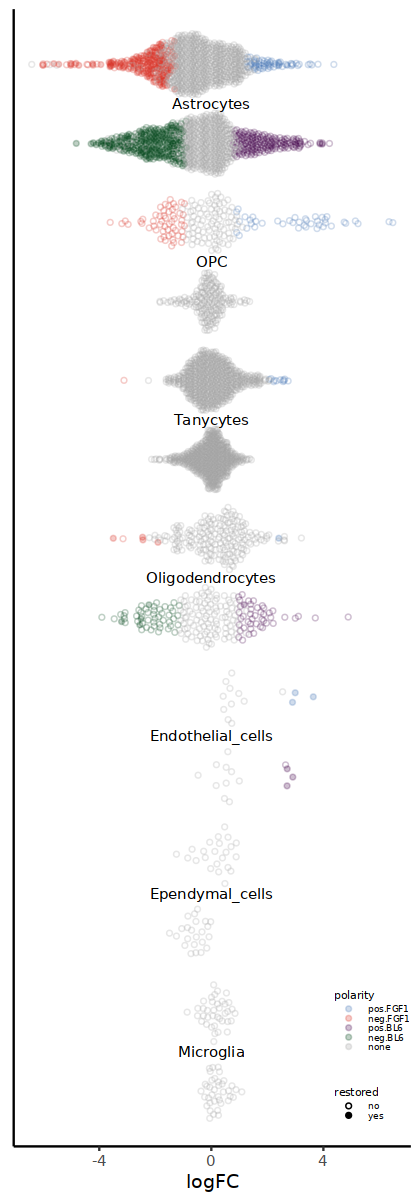

In [69]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

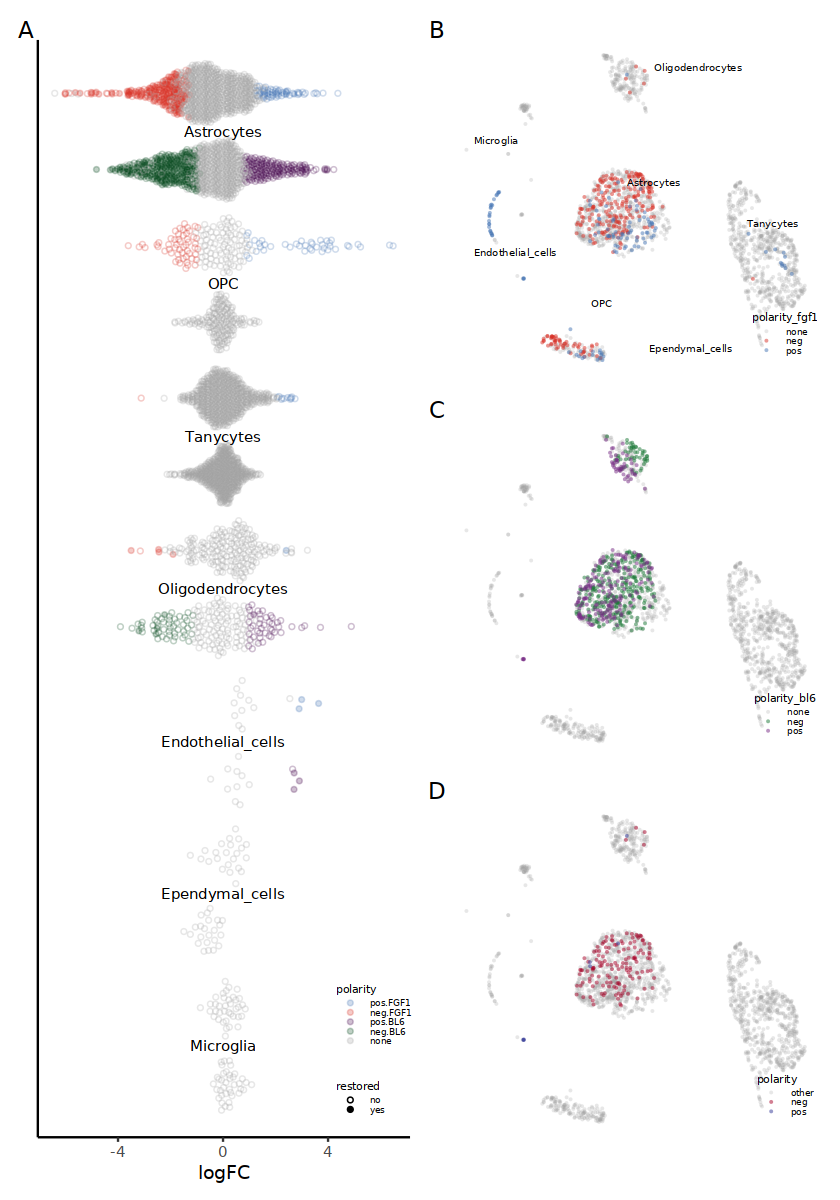

In [70]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_all_d5_vehall.pdf', plot = ., width = 7, height=9)
ggp

In [71]:
unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
# filter(n == 1) %>%
pull(labels)

unchanged_labels_bl6

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] "Agrp"                "Arx__Nr5a2"          "Astrocytes"         
 [4] "Dlk1"                "Endothelial_cells"   "Ependymal_cells"    
 [7] "Esr1"                "Fez1"                "Ghrh"               
[10] "Gpr50__Tac2"         "Hdc"                 "Htr3b"              
[13] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Lepr15"             
[16] "Lepr67"              "Lepr89"              "Lpar1_oligo"        
[19] "Met__Pappa2"         "Met__Prlh"           "Microglia"          
[22] "Nfib_1"              "Nfib_2"              "Nfib_3"             
[25] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"   
[28] "Npsr1__Epha3"        "OPC"                 "Oligodendrocytes"   
[31] "Pomc__Anxa2"         "Pomc__Glipr1"        "Pomc__Ttr"          
[34] "Pou6f2__Prkcq__Whrn" "Ppp1r17"             "Ppp1r17__Ltbp1"     
[37] "Ppp1r17__Tafa4"      "Reln__Lef1"          "Sim1"               
[40] "Slc17a6__Trhr"       "Sst__Nts"            "Sst__Pthlh"         
[43] "Sst__Unc13c"         "Tanycytes"           "Tbx19__Pirt"        
[46] "Th__Nfib"            "Th__Slc6a3"          "Tmem215__Dach2"     
[49] "Tmem215__Greb1"      "Trh__Cxcl12"         "Trh__Lef1"          
[52] "g1"                  "g2"                  "g3"                 
[55] "g4"                  "g_drop"              "n0"                 
[58] "n1"                  "n2"                  "n3"                 
[61] "n4"                  "n5"                  "n6"                 
[64] "n8"                  "n_drop"              "neuron"             
[67] "other"

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 32

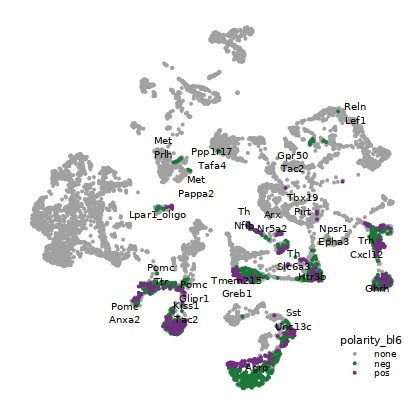

In [72]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 1, "neg" = 1, "pos"=1)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 41

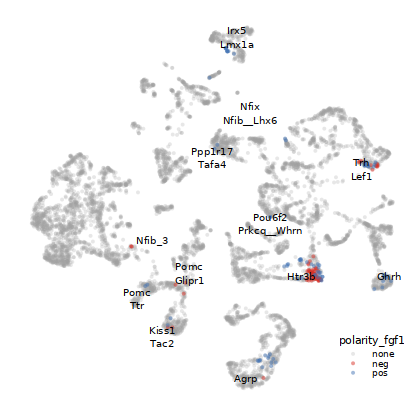

In [73]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

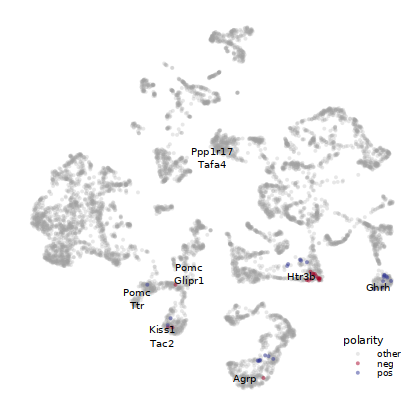

In [74]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

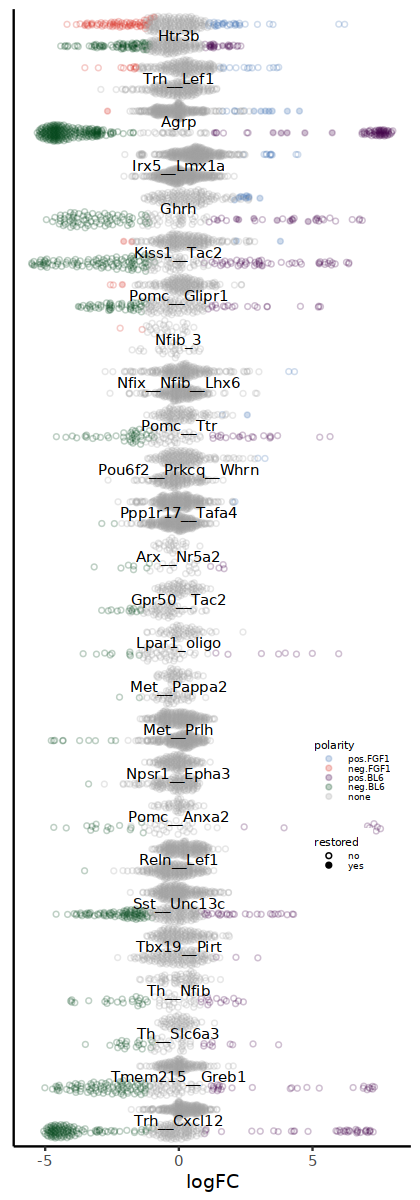

In [75]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

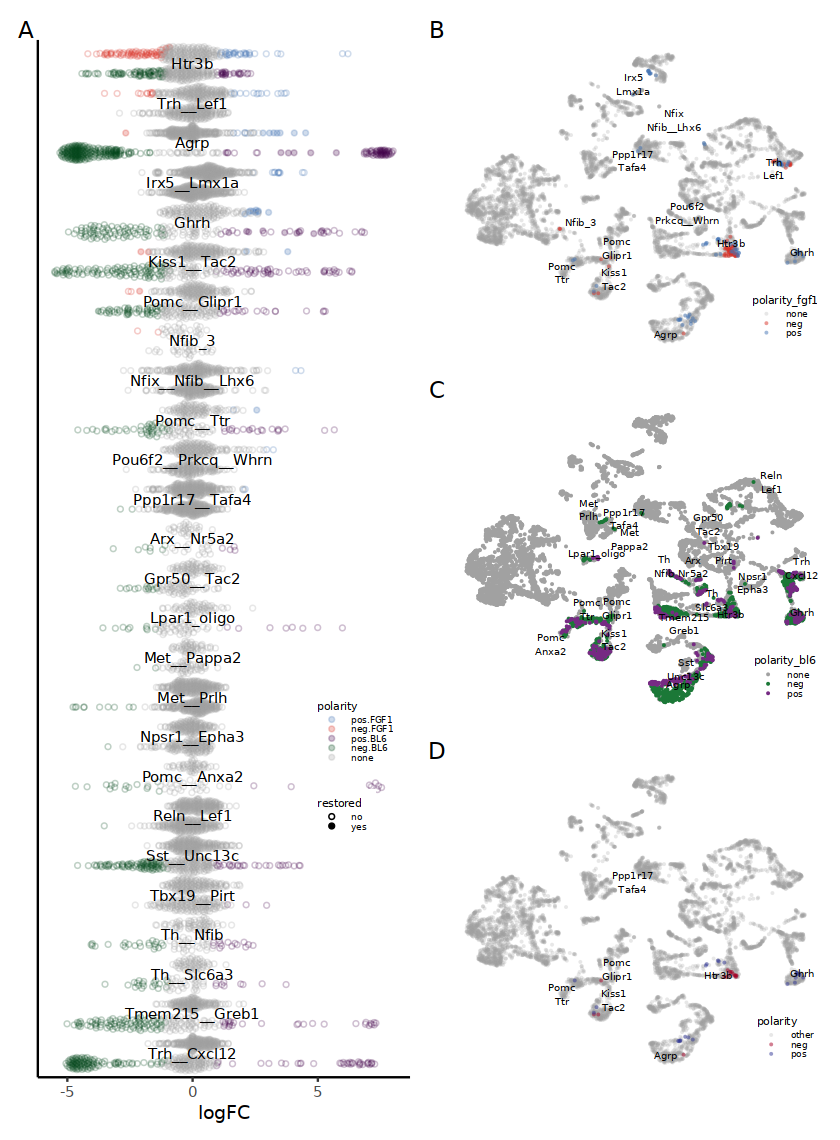

In [76]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_all_d5_vehall.pdf', plot = ., width = 7, height=9)
ggp

In [77]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_.qs')
da_results %>% qs::qsave('beeswarm_da_results_.qs')